In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import string
import time
from tqdm import tqdm
from itertools import chain

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.porter import *
import matplotlib.pyplot as plt
import seaborn as sns

import gensim
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim.test.utils import get_tmpfile

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
)
from sklearn import utils

In [2]:
import multiprocessing
multiprocessing.cpu_count()

8

In [5]:
filepath = "../data/clean_data.csv"
filepath_replaced = "../data/clean_data_replaced.csv"

In [6]:
df = pd.read_csv(filepath, encoding="utf_8")
df_replaced = pd.read_csv(filepath_replaced, encoding="utf_8")

In [7]:
df.groupby("label").count()

,text
label,
"Austen, Jane",9961
"Christie, Agatha",12354
"Dickens, Charles",25037
"Dostoyevsky, Fyodor",15421
"Hugo, Victor",23405
"London, Jack",11843
"Stowe, Harriett Beecher",12794
"Twain, Mark",10837


In [8]:
df.head(5)

,text,label
0,"My father’s family name being Pirrip, and my C...","Dickens, Charles"
1,"I give Pirrip as my father’s family name, on t...","Dickens, Charles"
2,"Ours was the marsh country, down by the river,...","Dickens, Charles"
3,"“Hold your noise!” cried a terrible voice, as ...","Dickens, Charles"
4,"A fearful man, all in coarse grey, with a grea...","Dickens, Charles"


In [9]:
df_replaced.head(5)

,text,label
0,My father’s family name being NNP and my Chris...,"Dickens, Charles"
1,I give NNP as my father’s family name on the a...,"Dickens, Charles"
2,NNP was the marsh country down by the river wi...,"Dickens, Charles"
3,“Hold your noise!” cried a terrible voice as a...,"Dickens, Charles"
4,A fearful man all in coarse grey with a great ...,"Dickens, Charles"


# Functions

In [10]:
def tokenize(text):

    tokens = map(lambda x: x.strip(string.punctuation), text.split())
    tokens = list(filter(None, tokens))
    
    return tokens

In [35]:
def create_tagged_doc(texts, labels):
    
    tagged_doc = [TaggedDocument(words=tokenize(texts[i]), tags=labels[i]) for i in range(len(texts))]
    
    return tagged_doc

In [19]:
def fit_doc2vec_model(train, test, epochs=20):
    
    # Create tagged document
    train_tagged = train.apply(
      lambda r: TaggedDocument(words=tokenize(r["text"]), tags=[r.label]), axis=1
    )
    test_tagged = test.apply(
      lambda r: TaggedDocument(words=tokenize(r["text"]), tags=[r.label]), axis=1
    )

    # Build vocabulary
    model_dbow = Doc2Vec(train_tagged, dm=0, vector_size=10, alpha=0.025, negative=2, hs=0, min_count=5, sample=0)

    # Train Doc2Vec model
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=epochs)

    return model_dbow


In [66]:
def create_vec_for_learning(model, tagged_docs):

    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in tagged_docs])
    
    return targets, regressors

In [13]:
def fit_model(model, X_train, X_test, y_train, y_test):

    start_time = time.time()

    # Train model
    clf = model.fit(X_train, y_train)

    # Predict on test
    y_pred = clf.predict(X_test)

    end_time = time.time()

    print("Accuracy is: %f" % accuracy_score(y_pred, y_test))
    print("Precision is: %f" % precision_score(y_pred, y_test, average="macro"))
    print("Recall is: %f" % recall_score(y_pred, y_test, average="macro"))
    print("F1 score is: %f" % f1_score(y_pred, y_test, average="macro"))
    print("Execution time: %0.2fs" % (end_time - start_time))

    return clf

In [82]:
def get_confusion_matrix(X, y_true, model):

    # Predicted label
    y_pred = model.predict(X)

    # Confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred, normalize="true")
    df_cm = pd.DataFrame(cf_matrix, columns=np.unique(y_true), index=np.unique(y_true))
    df_cm.index.name = "Actual"
    df_cm.columns.name = "Predicted"

    return df_cm

In [90]:
def predict_text_print(text, label, doc2vec_model, model):

    pars_tokenized = [tokenize(x) for x in text]
    predict_vector = [doc2vec_model.infer_vector(doc, steps=20) for doc in pars_tokenized] 

    predict_label = model.predict(predict_vector)

    output = pd.DataFrame(
        {"TEXT": text, "PREDICTED LABEL": predict_label, "ACTUAL LABEL": label}
    )
    parsed = json.loads(output.to_json(orient="index"))
    output_json = json.dumps(parsed, indent=4)

    print(output_json)

# Setup

In [15]:
texts = list(df["text"])
texts_replaced = list(df_replaced["text"])
labels = list(df["label"])

In [16]:
# Split into train / test set
train, test = train_test_split(
    df, test_size=0.2, random_state=414
)

In [17]:
# Split into train / test set
train_replaced, test_replaced = train_test_split(
    df_replaced, test_size=0.2, random_state=414
)

In [30]:
# Create tagged document
train_tagged = train.apply(
  lambda r: TaggedDocument(words=tokenize(r["text"]), tags=[r.label]), axis=1
)
test_tagged = test.apply(
  lambda r: TaggedDocument(words=tokenize(r["text"]), tags=[r.label]), axis=1
)

In [ ]:
# Create tagged document
train_tagged_replaced = train_replaced.apply(
  lambda r: TaggedDocument(words=tokenize(r["text"]), tags=[r.label]), axis=1
)
test_tagged_replaced = test_replaced.apply(
  lambda r: TaggedDocument(words=tokenize(r["text"]), tags=[r.label]), axis=1
)

Get features for Doc2Vec

In [24]:
%%time
model_dbow = fit_doc2vec_model(train, test)

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 4.05 µs


In [25]:
%%time
model_dbow_replaced = fit_doc2vec_model(train_replaced, test_replaced)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.72 µs


In [27]:
# model_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
# model_dbow_replaced.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

# Models

In [ ]:
y_train, X_train = create_vec_for_learning(model_dbow, train_tagged)
y_test, X_test = create_vec_for_learning(model_dbow, test_tagged)

In [ ]:
y_train, X_train_replaced = vec_for_learning(model_dbow_replaced, train_tagged_replaced)
y_test, X_test_replaced = vec_for_learning(model_dbow_replaced, test_tagged_replaced)

In [ ]:
model_lr1 = LogisticRegression(solver="liblinear", multi_class="ovr", random_state=414)

clf_lr1 = fit_model(model_lr1, X_train, X_test, y_train, y_test)

Accuracy is: 0.816366
Precision is: 0.798330
Recall is: 0.830917
F1 score is: 0.811929
Execution time: 5.03s


In [ ]:
clf_lr1_replaced = fit_model(model_lr1, X_train_replaced, X_test_replaced, y_train, y_test)

Accuracy is: 0.686573
Precision is: 0.657563
Recall is: 0.705907
F1 score is: 0.675111
Execution time: 5.27s


In [ ]:
model_svm1 = LinearSVC(C=0.5, multi_class="ovr", random_state=414)

clf_svm1 = fit_model(model_svm1, X_train, X_test, y_train, y_test)

Accuracy is: 0.816613
Precision is: 0.799390
Recall is: 0.828454
F1 score is: 0.811557
Execution time: 13.77s


In [ ]:
clf_svm1_replaced = fit_model(model_svm1, X_train_replaced, X_test_replaced,
                              y_train, y_test)

Accuracy is: 0.684846
Precision is: 0.656094
Recall is: 0.701985
F1 score is: 0.672585
Execution time: 18.05s


In [ ]:
model_dbow.save("model_dbow")
model_dbow_replaced.save("model_dbow_replaced")

In [ ]:
import pickle as pkl

file_out_lr = "model_lr_dbow.pkl"
file_out_lr_replaced = "model_lr_dbow_replaced.pkl"
file_out_svm = "model_svm_dbow.pkl"
file_out_svm_replaced = "model_svm_dbow_replaced.pkl"

pkl.dump(clf_lr1, open(file_out_lr, 'wb'))
pkl.dump(clf_lr1_replaced, open(file_out_lr_replaced, 'wb'))
pkl.dump(clf_svm1, open(file_out_svm, 'wb'))
pkl.dump(clf_svm1_replaced, open(file_out_svm_replaced, 'wb'))

# Visualize Results

In [ ]:
cf_matrix1 = get_confusion_matrix(X_test, y_test, clf_lr1)

In [ ]:
cf_matrix2 = get_confusion_matrix(X_test, y_test, clf_svm1)

In [ ]:
cf_matrix1_replaced = get_confusion_matrix(
    X_test_replaced,
    y_test,
    clf_lr1_replaced,
)

In [ ]:
cf_matrix2_replaced = get_confusion_matrix(
    X_test_replaced,
    y_test,
    clf_svm1_replaced,
)

In [84]:
def create_cf_viz(cf, model_name, colors="Blues"):

    fig, ax = plt.subplots(figsize=(12, 8))

    ax = sns.set(font_scale=1.2)
    ax = sns.heatmap(
        cf,
        cmap=colors,
        vmin=0,
        vmax=1,
        annot=True,
        annot_kws={"size": 14},
    )

    ax.set_title("Actual vs. Predicted Labels: " + model_name)
    plt.xticks(rotation=45)

    plt.show()

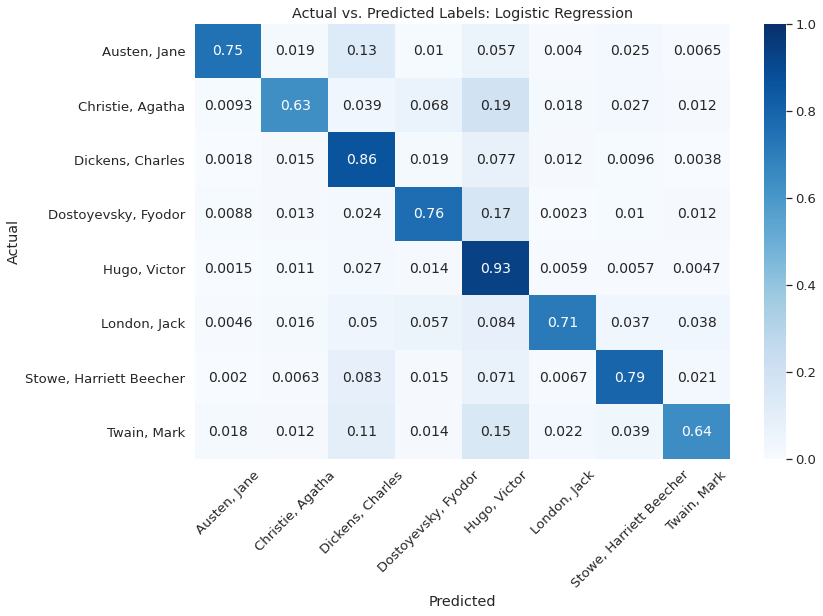

In [ ]:
create_cf_viz(cf_matrix1, "Logistic Regression")

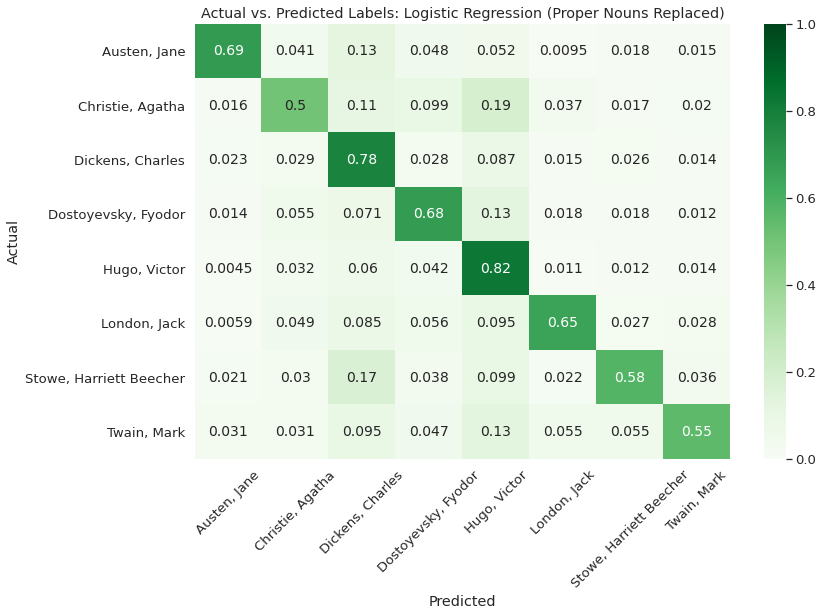

In [ ]:
create_cf_viz(cf_matrix1_replaced, "Logistic Regression (Proper Nouns Replaced)", colors="Greens")

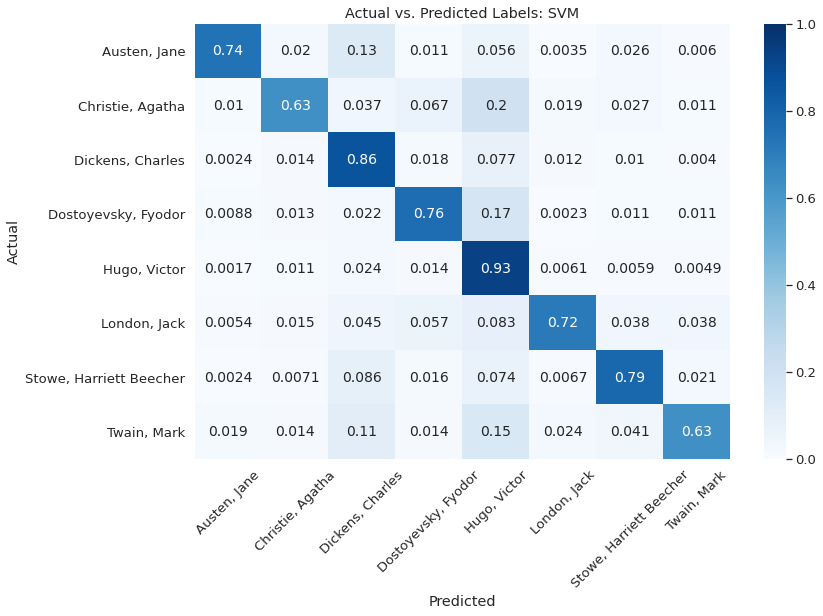

In [ ]:
create_cf_viz(cf_matrix2, "SVM")

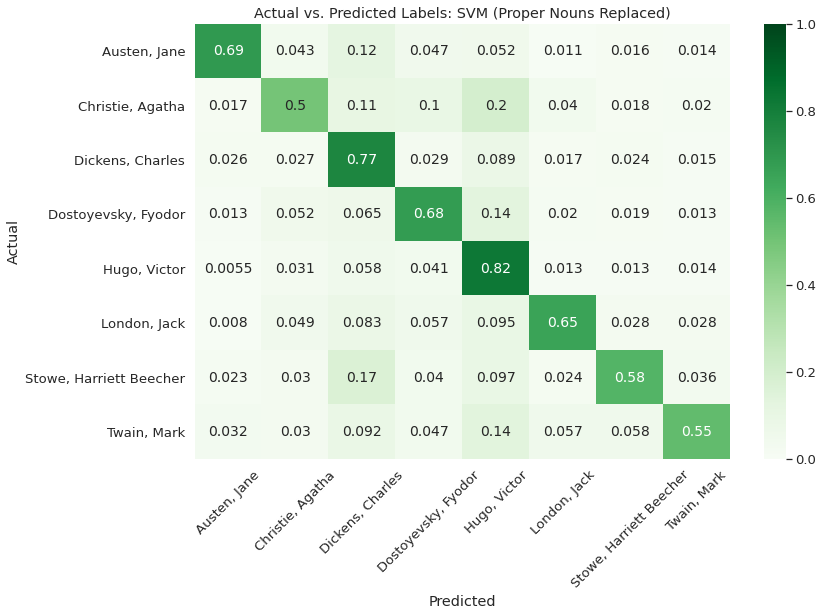

In [ ]:
create_cf_viz(cf_matrix2_replaced, "SVM (Proper Nouns Replaced)", colors="Greens")

In [93]:
def output_viz(X, y, doc2vec_model, model, model_name, file_name, colors="Blues"):

    # Vectorize texts
    X_vectorized = create_vec_for_prediction(doc2vec_model, X)

    # Get confusion matrix
    cf = get_confusion_matrix(X_vectorized, y, model)

    # Create visualization
    create_cf_viz(cf, model_name, colors)

In [79]:
def create_vec_for_prediction(model, texts):

    pars_tokenized = [tokenize(text) for text in texts]
    pred_vector = [model.infer_vector(doc, steps=20) for doc in pars_tokenized]

    return pred_vector

In [105]:
_, X_test, _, y_test = train_test_split(
    list(df_replaced["text"]),
    list(df_replaced["label"]),
    test_size=0.2,
    random_state=414
)

In [106]:
X_vectorized = create_vec_for_prediction(model_dbow_replaced, X_test)

In [107]:
y_pred = model.predict(X_vectorized)

In [108]:
cf_matrix = get_confusion_matrix(X_vectorized, y_test, model)

In [109]:
cf_matrix.shape

(8, 8)

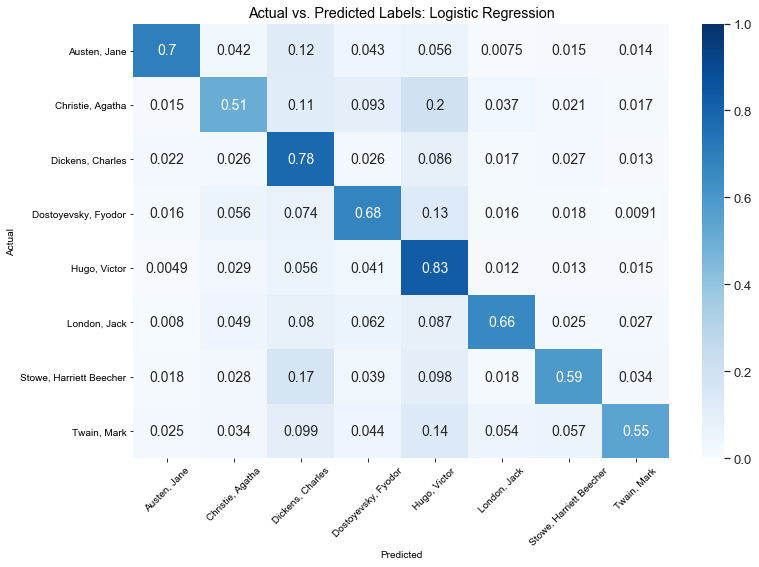

In [94]:
output_viz(
    X_test,
    y_test,
    model_dbow_replaced,
    model,
    "Logistic Regression",
    "temp.png",
    colors="Blues",
)

# Predict

In [88]:
sample_index = [
    0,
    5000,
    10000,
    20000,
    30000,
    40000,
    50000,
    60000,
    70000,
    80000,
    90000,
    10000,
    110000,
]

In [89]:
# Sample text
sample_text = [texts_replaced[i] for i in sample_index]

# Sample labels
sample_labels = [labels[i] for i in sample_index]

In [91]:
predict_text_print(
    sample_text,
    sample_labels,
    model_dbow_replaced,
    model
)

{
    "0": {
        "TEXT": "My father\u2019s family name being NNP and my Christian name NNP my infant tongue could make of both names nothing longer or more explicit than NNP So I called myself NNP and came to be called NNP",
        "PREDICTED LABEL": "Dickens, Charles",
        "ACTUAL LABEL": "Dickens, Charles"
    },
    "1": {
        "TEXT": "I doubt if he had ever once thought of it before",
        "PREDICTED LABEL": "Dickens, Charles",
        "ACTUAL LABEL": "Dickens, Charles"
    },
    "2": {
        "TEXT": "With this peroration NNP NNP buttoned up goes quietly out looking steadily before him as if he were already piercing the night in quest of the fugitive",
        "PREDICTED LABEL": "Dickens, Charles",
        "ACTUAL LABEL": "Dickens, Charles"
    },
    "3": {
        "TEXT": "Among the talkers was NNP of the NNP NNP NNP far on his way to state promotion and therefore loud on the theme broaching to NNP his devices for blowing the people up and exterminating them fr

# Load from File

In [104]:
import pickle as pkl

model_dbow_replaced = Doc2Vec.load('../models/model_dbow_replaced')

with open('../models/model_lr_dbow_replaced.pkl', 'rb') as f:
    model = pkl.load(f)

/Users/catherineyang/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [58]:
sents = [tokenize(text) for text in test["text"]]
predict_vector = [model_dbow_replaced.infer_vector(doc, steps=20) for doc in sents]

In [61]:
predicted = model.predict(predict_vector)

In [62]:
predicted

array(['London, Jack', 'Dickens, Charles', 'Dostoyevsky, Fyodor', ...,
       'Stowe, Harriett Beecher', 'Dostoyevsky, Fyodor',
       'Christie, Agatha'], dtype='<U23')